Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm_21 (LSTM)              (None, 128)                  67584     ['input_22[0][0]']            
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_21[0][0]']             
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm_21[0][0]']             
                                                                                           

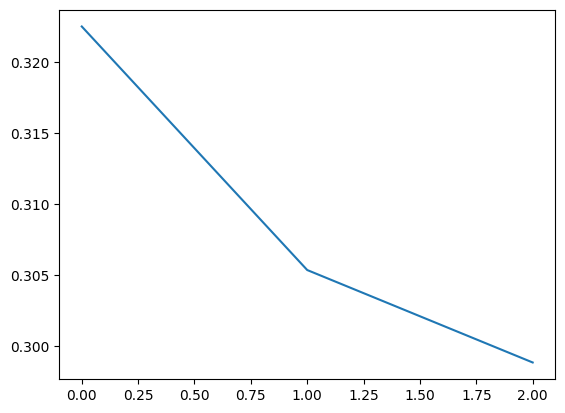

1/1 [==============================] - 0s 16ms/step


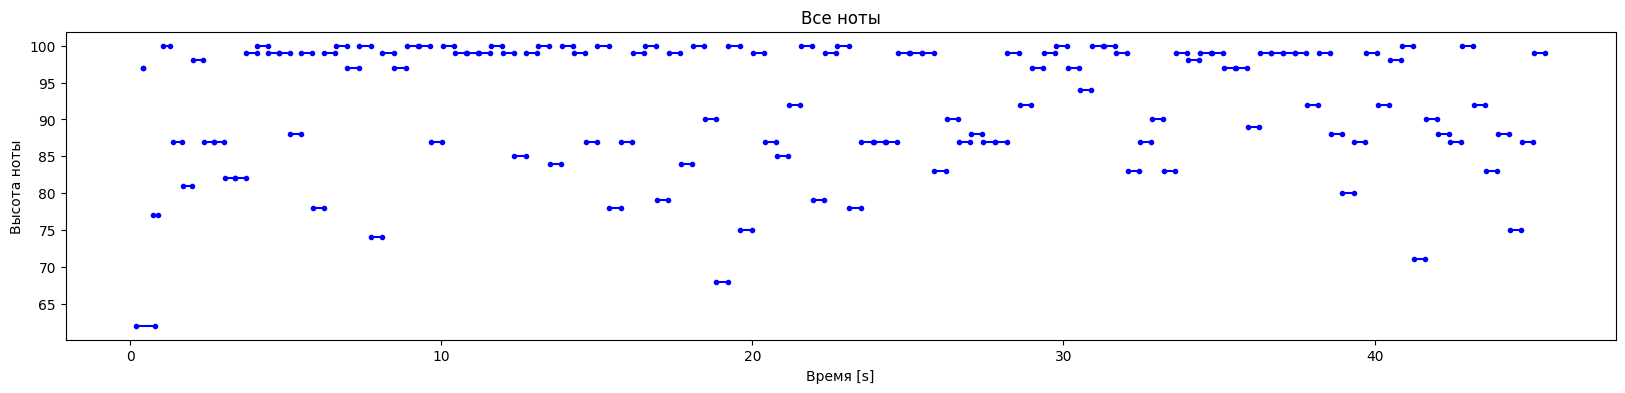

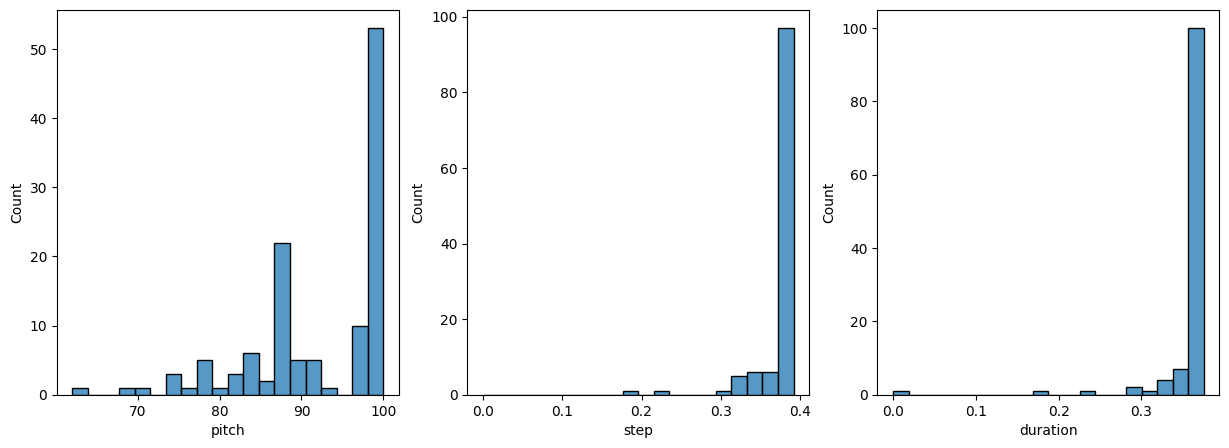

In [23]:
import fluidsynth
import datetime
import collections
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple


# Отображение музыкального файла в Jupyter
def display_audio(pm, seconds=30):
    waveform = pm.fluidsynth(fs=float(_SAMPLING_RATE))
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)


# Преобразование миди в словарь с нотами
def midi_to_notes(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Сортируем ноты по времени
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    
    # Формируем датафрейм с нотами и их характеристиками
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch) # высота тона
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start) # время, прошедшее с начала предыдущей ноты
        notes['duration'].append(end - start) # продолжительность воспроизведения ноты в секундах
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})


# Отображение нот (count - ограничение на колличество нот)
def plot_piano_roll(notes, count=None):
    if count:
        title = f'Первые {count} нот'
    else:
        title = f'Все ноты'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    # Координаты начала и конца сопоставляем координатам высоты
    plt.plot(
        plot_start_stop[:count, :count], plot_pitch[:count, :count], color="b", marker=".")
    plt.xlabel('Время [s]')
    plt.ylabel('Высота ноты')
    plt.title(title)
    
    
# Отображение статистики по характеристикам в виде гистограмм
def plot_distributions(notes, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))


# Преобразование нот в миди
def notes_to_midi(notes, out_file, instrument_name, velocity = 100):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

    prev_start = 0
    # Проходимся по всем нотам и формируем соответствующую ноту в миди файле
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']), start=start, end=end)
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm


def create_sequences(dataset, seq_length, vocab_size = 128):
    # добавляем 1 для имен
    seq_length = seq_length+1

    # Делит датасет на подмножества длиной seq_length(shift - нумерация, stride - отображение, drop_remainder - полное заполнение)
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
        
    # Формируем лямбда функцию, которая разбивает подмножества на отдельные элементы
    # Функция batch делит датасет на seq_length последовательностей
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    # Применяем функцию ко всем элементам датасета, получая датасет формы [26, 3]
    sequences = windows.flat_map(flatten)

    # Модификация высоты ноты
    def scale_pitch(x):
        x = x/[vocab_size, 1.0, 1.0]
        return x

    # Добавляем в датасет словарь со следующей нотой, которую программа должна предсказать
    # За значение по-умолчанию берем 26 ноту из каждого массива
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key: labels_dense[i] for i, key in enumerate(key_order)}

        return scale_pitch(inputs), labels
    
    # Применяем split_labels к каждому массиву в датасете
    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)


# Среднеквадратичная ошибка
def mse_with_positive_pressure(y_true, y_pred):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)


# Функция предсказывания следующей ноты на основе модели
def predict_next_note(notes, keras_model, temperature = 1.0):
    # Добавляем новое измерение к нотам (иначе возникает ошибка)
    inputs = tf.expand_dims(notes, 0)
    
    # Предсказываем характеристики по модели
    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']
    
    # Температура отвечает за случайность результатов
    pitch_logits /= temperature
    # Находим категориальное распределение высоты ноты (наиболее вероятное значение из списка)
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    # Убираем лишнее измерение
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # step и duration должны быть положительными
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)


# Рандомизация tensorFlow
seed = 50
tf.random.set_seed(seed)
np.random.seed(seed)

# Частота дискретизации
_SAMPLING_RATE = 16000

# Скачиваем датасет
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'maestro-v2.0.0-midi.zip',
        origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
        extract=True,
        cache_dir='.', cache_subdir='data',
    )

filenames = glob.glob(str(data_dir/'**/*.mid*'))

# Берем любой файл из директории и сохраняем информацию об инструменте
sample_file = filenames[1]
pm = pretty_midi.PrettyMIDI(sample_file)
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

display_audio(pm)

raw_notes = midi_to_notes(sample_file)

example_file = 'example.midi'
example_pm = notes_to_midi(raw_notes, out_file=example_file, instrument_name=instrument_name)

# Создание набора данных для обучения (берем ноты из нескольких файлов и объединяем в один датафрейм)
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)

# Формируем датафрейм из трех характеристик
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

# Создаем датасет, состоящий из трех срезов датафрейма(по первому измерению)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)

seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

batch_size = 64
buffer_size = n_notes - seq_length  # кол-во айтемов в датасете
# Настраиваем датасет таким образом, чтобы достичь максимальной производительности
train_ds = (seq_ds.shuffle(buffer_size).batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE))

input_shape = (seq_length, 3)
learning_rate = 0.005

# Создаем модель RNN
inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

# Слои нейросети (исследуемые переменные)
outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

# Разница между моделью и вычислениями (потеря)
loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

# Задаем метод оптимизации величин
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Настройка модели
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

# Вывод информации о модели
model.summary()

# Тестируем на потери
model.evaluate(train_ds, return_dict=True)

# ModelCheckpoint - сохранение прогресса во время обучения между чекпоинтами
# EarlyStopping - прекращение обучения при условии, что результаты не изменяются от итерации к итерации
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

# Колличество итераций (чекпоинтов)
epochs = 3

# Тренировка модели
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

# Вывод отчета о потерях
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

temperature = 2.0
# Колличество предсказанных нот
num_predictions = 120

# Вытащим из исходного датафрейма нужные характеристики
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# Начальная последовательность нот, высота тона нормализуется как во время тренировки
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for i in range(num_predictions):
    # Предсказываем ноту
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    # Задаем начало и конец
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    # Распаковываем характеристики и добавляем к ним начало и конец
    generated_notes.append((*input_note, start, end))
    # Удаляем первый элемент и подставляем сгенерированный элемент в конец начальной последовательности
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

# Формируем датафрейм из сгенерированных нот
generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

# Переводим сгенерированную мелодию в миди и сохраняем как файл
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)


# Отображение статистики
plot_piano_roll(generated_notes)

plot_distributions(generated_notes)

# Прослушивание midi в Jupyter
display_audio(out_pm)
